In [1]:
from qwak.qwak import QWAK

import networkx as nx
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from math import sqrt, ceil, pow
from scipy.linalg import expm
import math
import copy
import matplotlib.pyplot as plt
import os
from utils.plotTools import plot_qwak


In [ ]:
def write_nested_list_to_file(file_path, nested_lst):
    """
    Write a nested list of elements to a text file.
    
    :param file_path: the file path where to write the nested list
    :param nested_lst: the nested list of elements to write
    """
    with open(file_path, 'w') as f:
        for lst in nested_lst:
            for item in lst:
                f.write(f"{item} ")
            f.write("\n")

def load_nested_list_from_file(file_path):
    """
    Load a nested list of float elements from a text file.
    
    :param file_path: the file path to load the nested list from
    :return: the nested list of float elements loaded from the file
    """
    nested_lst = []
    with open(file_path, 'r') as f:
        for line in f:
            lst = [float(item) for item in line.strip().split()]
            nested_lst.append(lst)
    return nested_lst

def gamma_hypercube(n):
    total = 0
    for r in range(1, n + 1):
        binomial_coefficient = math.comb(n, r)
        total += binomial_coefficient * (1 / r)
    return ((1 / (2 ** n)) * total)/2

# Single walk search

0.7392917736281377


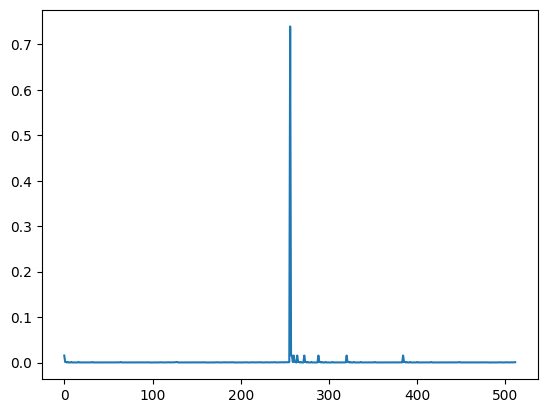

In [3]:
n=9
graph = nx.hypercube_graph(n)
gamma = gamma_hypercube(n) # Gamma do paper do renato https://arxiv.org/pdf/2212.08889.pdf

N = len(graph)
markedElements = [(N//2,-1)]

t = np.floor(np.pi/2 * sqrt(N))
# t = 43
initCond = list(range(0,len(graph)))


qw = QWAK(graph=graph,gamma=gamma,markedElements=markedElements,laplacian=False)
qw.runWalk(time=t,initStateList=initCond)
print(max(qw.getProbVec()))
plt.plot(qw.getProbVec())


# Multiple walk search

In [4]:
def searchProbStepsPlotting2(qwak: QWAK, probDistList):
    """Plots the probability of finding the target as a function of the number of steps.

    Parameters
    ----------
    qwak : QWAK
        QWAK object containing the results of the simulation.
    """
    markedProbability = 0
    markedProbDistList = []
    markdElements = qwak.getMarkedElements()
    probDistList = probDistList
    if probDistList == []:
        raise EmptyProbDistList(
            "The probability distribution list is empty.")
    for probDist in probDistList:
        for element in markdElements:
            markedProbability += probDist.searchNodeProbability(
                element[0])
        markedProbDistList.append(markedProbability)
        markedProbability = 0
    return markedProbDistList

def multiple_hypercube_qwak(N,gammaList,timeList,markedElements,initCond):
    markedProbList = []
    markedElementsMatrix = []
    timeMatrix = []
    probDistList = []
    markedProbMatrix = []
    sampleCounter = 1
    for gamma in gammaList:
        qw = QWAK(graph=graph,gamma=gamma,markedElements=markedElements,laplacian=False)
        print(f'GAMMA {round(gamma, 4)}/{max(gammaList)} \t Sample {sampleCounter}/{len(gammaList)}')
        sampleCounter += 1
        for time in timeList:
            qw.runWalk(time=time,initStateList=initCond)
            probDistList.append(copy.deepcopy(qw.getProbDist()))
        markedProbList = searchProbStepsPlotting2(qw,probDistList)
        markedProbMatrix.append(markedProbList)
        probDistList = []
        markedElementsMatrix.append(markedElements)
        timeMatrix.append( timeList)
    return markedProbMatrix,markedElementsMatrix,timeMatrix

In [5]:
n=9
graph = nx.hypercube_graph(n)
gamma = gamma_hypercube(n)
gammaMin = gamma/1.10

N = len(graph)
t =  (np.pi/(2) * np.sqrt(N))
maxTime = 2.2*t

print(f'N = {N}')
print(f'GammaMin = {gammaMin}')
print(f'T = {t}')

initCond = list(range(0,len(graph)))

samples = 200
timeList = np.linspace(0,maxTime,samples)
print(max(timeList))
gammaList =  np.linspace(gammaMin,gamma ,samples).tolist()
markedElements = [(N//2,-1)]

colors = plt.cm.rainbow(np.linspace(0, 1, len(gammaList)))
lines = ['-']*len(gammaList)
configVec = list(zip(colors,lines))

N = 512
GammaMin = 0.11725760675955989
T = 35.54306350526693
78.19473971158725


In [6]:
time_file = f'Datasets/HypercubeSearch/timeMatrix_N{N}_S{samples}_GMIN{round(gammaMin,3)}_TMAX{round(maxTime)}.txt'
markedElements_file = f'Datasets/HypercubeSearch/markedElementsMatrix_N{N}_S{samples}_GMIN{round(gammaMin,3)}_TMAX{round(maxTime)}.txt'
marked_prob_file = f'Datasets/HypercubeSearch/markedProbMatrix_N{N}_S{samples}_GMIN{round(gammaMin,3)}_TMAX{round(maxTime)}.txt'

if os.path.exists(time_file) and os.path.exists(markedElements_file) and os.path.exists(marked_prob_file):
    markedProbMatrix = load_nested_list_from_file(marked_prob_file)
    markedElementsMatrix = load_nested_list_from_file(markedElements_file)
    timeMatrix = load_nested_list_from_file(time_file)
    print('File exists!')
else:
    print('File Doesnt Exist!')
    markedProbMatrix,markedElementsMatrix,timeMatrix = multiple_hypercube_qwak(N,gammaList,timeList,markedElements,initCond)
    if not os.path.exists(markedElements_file):
        write_nested_list_to_file(markedElements_file, markedProbMatrix)
    if not os.path.exists(time_file):
        write_nested_list_to_file(time_file, timeMatrix)
    if not os.path.exists(marked_prob_file):
        write_nested_list_to_file(marked_prob_file, markedProbMatrix)

File exists!


[(43.61616134666424, 0.7867983968794232)]
0.7867983968794232


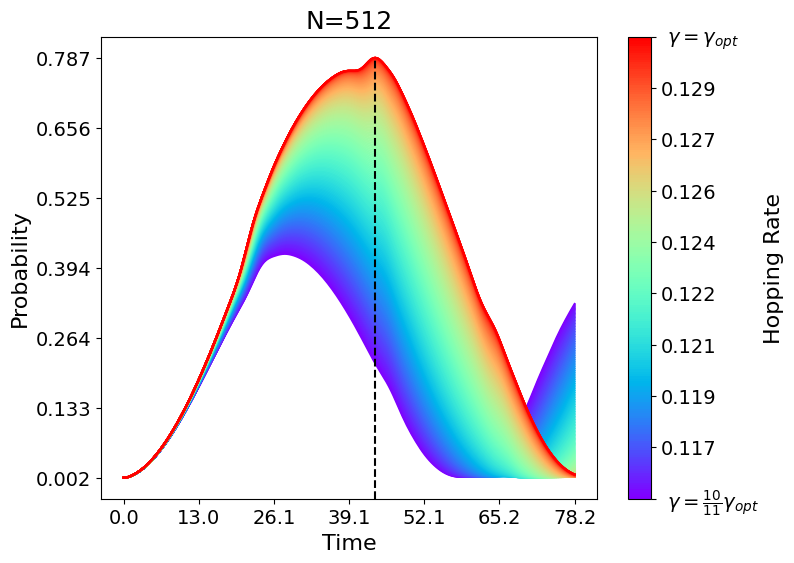

In [10]:
color_list = plt.cm.rainbow(np.linspace(0, 1, len(gammaList)))

v_line_values = [(timeMatrix[-1][np.argmax(markedElementsMatrix[-1])],np.max(markedElementsMatrix[-1]))]
print(v_line_values)

cbar_num_ticks = 10
params = {
    'font_size' : 14,
    'figsize': (8, 6),
    'plot_title' : f'N={N}',
    'x_label' : 'Time',
    'y_label' : 'Probability',
    'legend_labels' : None,
    'legend_loc': None,
    'legend_title' : 'Solutions',
    'legend_ncol' : 1,
    # 'color_list' : ['#0000FF', '#008000', '#525252'],
    'color_list' : color_list,
    # 'line_style_list' : ['--', '-','-.' ],
    'save_path' : f'Output/HypercubeSearch/hypercubePlot_N{N}_S{samples}_GMIN{round(gammaMin,3)}_TMAX{round(maxTime)}.png',
    'use_loglog': False,
    'use_cbar' : True,
    'cbar_label' : 'Hopping Rate', 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'cbar_ticks_generator': gammaList,
    'cbar_tick_labels': [r' $\gamma = \frac{10}{11}\gamma_{opt}$'] + [f'{round(x,3)}' for x in np.linspace(gammaMin,gamma ,cbar_num_ticks-2).tolist()] + [r' $\gamma = \gamma_{opt}$'],
    'cbar_num_ticks' : cbar_num_ticks,
    'x_lim' : None,
    'x_num_ticks' : 7,
    'y_num_ticks' : 7,
    'x_round_val' : 1,
    'y_round_val' : 3,
    'v_line_values' : v_line_values,
    'v_line_style': '--',
    'v_line_list_index' : len(gammaList)-1,
}
print(v_line_values[0][1])

plot_qwak(x_value_matrix = timeMatrix, y_value_matrix = markedElementsMatrix,**params)